In [2]:
import numpyro.distributions as dist
from numpyro.infer import NUTS, MCMC, Predictive
from numpyro.infer.util import log_likelihood
import numpyro

from jax import jit, vmap, random, jacrev, hessian
import jax.numpy as jnp
import jax

import optax

import numpy as np

import matplotlib.pyplot as plt

/Users/chrisfinlay/mambaforge/envs/pyro/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
args = {
    'sigma': 4.,
    'N1': 1000,
    'N2': 5,
}

true_params = {
    'c': jnp.arange(args['N2']).astype(float),
    'm': 7.*jnp.arange(args['N2']).astype(float), 
}

x = np.sort(np.random.random((args['N1'],args['N2'])), axis=0)
y = true_params['m'] * x + true_params['c']
y_obs = y + args['sigma']*np.random.randn(args['N1'],args['N2'])

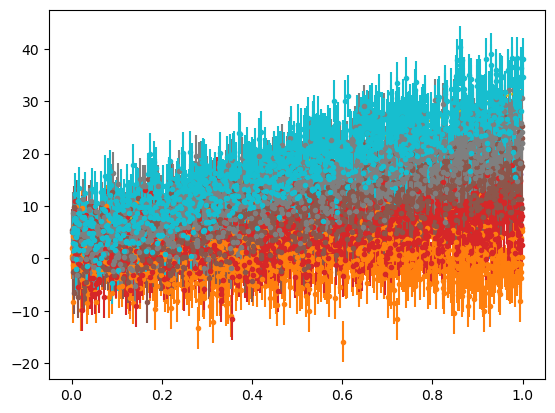

In [4]:
for i in range(args['N2']):
    plt.plot(x[:,i], y[:,i], '-')
    plt.errorbar(x[:,i], y_obs[:,i], args['sigma'], fmt='.')

In [5]:
def model(x, args, y_obs=None):
    N = x.shape[1]
    m = numpyro.sample('m', dist.Normal(jnp.zeros(N), 1))
    c = numpyro.sample('c', dist.Normal(jnp.zeros(N), 1))
    y = numpyro.deterministic('y', m*x + c)
    
    if y_obs is not None:
        numpyro.sample('obs', dist.Normal(y, args['sigma']), obs=y_obs)

In [6]:
num_warmup = 500
num_samples = 1000

nuts_kernel = NUTS(model, dense_mass=False) 
mcmc = MCMC(nuts_kernel, num_warmup=num_warmup, num_samples=num_samples)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, x=x, args=args, y_obs=y_obs, extra_fields=("potential_energy",))

mcmc_params = mcmc.get_samples()

pred = Predictive(model, posterior_samples=mcmc_params)
mcmc_pred = pred(random.PRNGKey(2), x=x, args=args, y_obs=y_obs)

sample: 100%|████████████████████| 1500/1500 [00:01<00:00, 1205.97it/s, 15 steps of size 3.33e-01. acc. prob=0.88]


In [7]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      c[0]      0.13      0.23      0.12     -0.28      0.46    778.92      1.00
      c[1]      1.54      0.23      1.55      1.15      1.91    887.52      1.00
      c[2]      2.84      0.22      2.84      2.48      3.19   1124.81      1.00
      c[3]      4.60      0.23      4.61      4.23      4.96    950.91      1.00
      c[4]      6.37      0.22      6.37      6.01      6.72   1001.48      1.00
      m[0]     -0.19      0.39     -0.18     -0.84      0.43    888.30      1.00
      m[1]      6.36      0.39      6.34      5.69      6.98    895.36      1.00
      m[2]     12.39      0.38     12.37     11.81     13.01   1012.37      1.00
      m[3]     17.76      0.38     17.75     17.16     18.40    921.90      1.00
      m[4]     23.15      0.38     23.15     22.53     23.76   1044.25      1.00

Number of divergences: 0


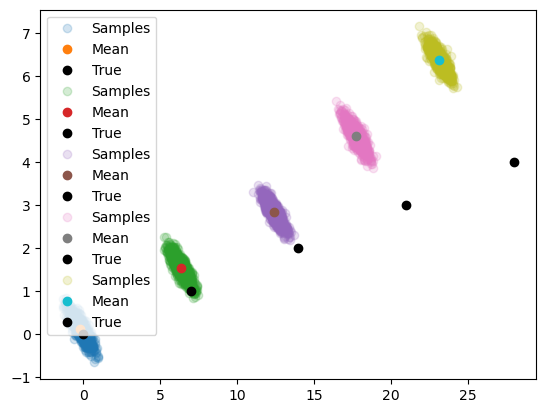

In [8]:
for i in range(args['N2']):
    plt.plot(mcmc_params['m'][:,i], mcmc_params['c'][:,i], 'o', alpha=0.2, label='Samples')
    plt.plot(mcmc_params['m'][:,i].mean(), mcmc_params['c'][:,i].mean(), 'o', label='Mean')
    plt.plot(true_params['m'][i], true_params['c'][i], 'ko', label='True')
    plt.legend()

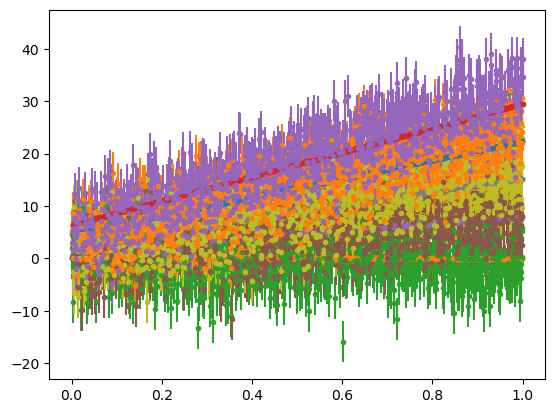

In [9]:
for i in range(args['N2']):
    plt.plot(x[:,i], y[:,i], '-')
    plt.errorbar(x[:,i], mcmc_pred['y'][:,:,i].mean(axis=0), mcmc_pred['y'][:,:,i].std(axis=0), fmt='.')
    plt.errorbar(x[:,i], mcmc_pred['obs'][:,:,i].mean(axis=0), args['sigma'], fmt='.')

In [10]:
nll = lambda params, x, y_obs: -1*log_likelihood(model, posterior_samples=params, x=x, args=args, y_obs=y_obs)['obs']
nll_sum = lambda params, x, y_obs: -1*log_likelihood(model, posterior_samples=params, x=x, args=args, y_obs=y_obs)['obs'].sum()

In [11]:
true_samples = jax.tree_map(lambda x: jnp.atleast_1d(x)[None,:], true_params)

In [12]:
2*nll(true_samples, x, y_obs).mean() - jnp.log(2*jnp.pi*args['sigma']**2)

Array(0.97815084, dtype=float32)

In [13]:
2*jnp.mean((y_obs - Predictive(model, posterior_samples=true_samples)(random.PRNGKey(2), x=x, args=args, y_obs=y_obs)['y'][0])**2)/(2*args['sigma']**2)

Array(0.97815126, dtype=float32)

In [14]:
from numpyro.infer.util import log_density

In [15]:
log_density(model, model_args=(), model_kwargs={'x': x, 'args': args, 'y_obs': None}, params=true_samples)[0], log_likelihood(model, posterior_samples=true_samples, x=x, args=args, y_obs=y_obs)['obs'].sum()

(Array(-759.1894, dtype=float32), Array(-13971.543, dtype=float32))

In [16]:
log_density(model, model_args=(), model_kwargs={'x': x, 'args': args, 'y_obs': y_obs}, params=true_samples)[0]

Array(-14730.732, dtype=float32)

# True Fisher

In [418]:
# jax.tree_map(lambda x: x.T@x, jacrev(nll, 0)(true_params, x, y_obs))

# True Fisher Diag : sum of squares

In [419]:
jax.tree_map(lambda x: 1./jnp.sqrt(jnp.sum(x**2)), jacrev(nll, 0)(true_samples, x, y_obs))

{'c': Array(0.05690196, dtype=float32),
 'c0': Array(0.05690196, dtype=float32),
 'm': Array(0.09650934, dtype=float32)}

In [420]:
fisher = lambda x, y: optax.fisher_diag(nll_sum, params=true_samples, inputs=x, targets=y)
F = vmap(fisher, in_axes=(0,0))(x[:,None], y_obs[:,None])
1./jnp.sqrt(F.sum(axis=0))

Array([0.12617618, 0.13226588, 0.12930596, 0.12453064, 0.12443482,
       0.05758657, 0.2092984 , 0.2136746 , 0.22152892, 0.22150907,
       0.21380147], dtype=float32)

# Hessian

In [422]:
H = jit(hessian(nll_sum, 0))
print('Std')
# HH = H(true_params, x, y_obs)
# jnp.sqrt(jnp.diag(jnp.linalg.inv(jnp.array(jax.tree_util.tree_flatten(H(true_params, x, y_obs))[0]).reshape(2,2))))

Std


In [176]:
jnp.sqrt(jnp.diag(jnp.linalg.inv(jnp.concatenate([ravel(HH['c']).reshape(4,2), ravel(HH['m']).reshape(4,2)], axis=1))))

NameError: name 'ravel' is not defined

In [273]:
%timeit 1./jnp.sqrt((jnp.diag(jnp.array(jax.tree_util.tree_flatten(H(true_params, x, y_obs))[0]).reshape(2,2))))

397 µs ± 825 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


# Dodgy fisher : square of sum

In [319]:
jax.tree_map(lambda x: 1./jnp.abs(x), jacrev(nll_sum, 0)(true_params, x, y_obs))

{'c': Array([0.00509299, 0.00581134], dtype=float32),
 'm': Array([0.01411066, 0.01725502], dtype=float32)}

In [320]:
%timeit 1./jnp.sqrt(optax.fisher_diag(nll_sum, params=true_params, inputs=x, targets=y_obs))

61.9 ms ± 794 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Optax Hessian

In [321]:
H = jit(optax.hessian_diag, static_argnums=(0,))

In [322]:
%timeit 1./jnp.sqrt(H(nll_sum, true_params, x, y_obs))

15.2 µs ± 180 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [356]:
1./jnp.sqrt(H(nll_sum, true_params, x, y_obs))

Array([0.03535534, 0.03535534, 0.05747207, 0.05747207], dtype=float32)

In [410]:
F = lambda params : optax.hvp(nll_sum, params, true_params, x, y_obs)
# jax.tree_map(lambda x: 1./jnp.sqrt(x), vmap(F)(jnp.eye(2)))
# jax.tree_map(lambda x: 1./x, vmap(F)(jnp.eye(2)))
# F({'c': 1., 'm': 0.})
# F(jnp.array([1., 0.]))

In [417]:
FF = vmap(F)(jnp.eye(4))

In [418]:
jnp.sqrt(jnp.diag(jnp.linalg.inv(jnp.concatenate([FF['c'], FF['m']], axis=1))))

Array([0.07356349, 0.07356349, 0.11958157, 0.11958157], dtype=float32)

In [421]:
1./jnp.sqrt(jnp.diag(jnp.concatenate([FF['c'], FF['m']], axis=1)))

Array([0.03535534, 0.03535534, 0.05747207, 0.05747207], dtype=float32)

# Fisher Vector Product

In [329]:
nll_fvp1 = lambda params: nll_sum(params, x, y_obs) # Dodgy
nll_fvp2 = lambda params: nll(params, x, y_obs)     # Good

In [330]:
from functools import partial

In [331]:
@partial(jit, static_argnums=(0,))
def fisher_vp(f, w, v):
    # J v 
    _, Jv = jax.jvp(f, (w,), (v,))
    # (J v)^T J = v^T (J^T J) 
    _, f_vjp = jax.vjp(f, w)
    return f_vjp(Jv)[0]

In [333]:
%timeit jax.tree_map(lambda x: 1./jnp.sqrt(x), fisher_vp(nll_fvp1, true_params, {'c': jnp.array([1., 0.]), 'm': jnp.array([1., 0.])}))['c'], jax.tree_map(lambda x: 1./jnp.sqrt(x), fisher_vp(nll_fvp1, true_params, {'c': jnp.array([1., 0.]), 'm': jnp.array([1., 0.])}))['m']

208 µs ± 1.53 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [335]:
%timeit jax.tree_map(lambda x: 1./jnp.sqrt(x), fisher_vp(nll_fvp2, true_params, {'c': jnp.array([1., 0.]), 'm': jnp.array([1., 0.])}))['c'], jax.tree_map(lambda x: 1./jnp.sqrt(x), fisher_vp(nll_fvp2, true_params, {'c': jnp.array([1., 0.]), 'm': jnp.array([1., 0.])}))['m']

201 µs ± 393 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [350]:
from jax.flatten_util import ravel_pytree

def ravel(p):
    return ravel_pytree(p)[0]

@partial(jit, static_argnums=(0,))
def fisher_diag(nll, params):
    params_flat, unflatten = ravel_pytree(params)
    N = len(params_flat)
    vs = jnp.eye(N)
    comp = lambda v: jnp.vdot(v, ravel(fisher_vp(nll_fvp2, params, unflatten(v))))
    return unflatten(jax.vmap(comp)(vs))

In [445]:
%timeit jax.tree_map(lambda x: 1./jnp.sqrt(x), fisher_diag(nll, true_samples))

23.1 µs ± 79.2 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [444]:
jax.tree_map(lambda x: 1./jnp.sqrt(x), fisher_diag(nll, true_samples))

{'c': Array([[0.05105438, 0.04748626]], dtype=float32),
 'm': Array([[0.08438952, 0.08507594]], dtype=float32)}

In [357]:
true_params_flat, unflatten = ravel_pytree(true_params)

In [400]:
@jit
def nll_flat(params):
    return nll_fvp2(unflatten(params))
    
@jit
def fvp(v):
    return fisher_vp(nll_fvp2, true_params, unflatten(v))

In [366]:
inv_f = lambda x: jax.scipy.sparse.linalg.cg(fvp, unflatten(x))
F_inv = vmap(inv_f)(jnp.eye(4))

In [380]:
jnp.concatenate([F_inv[0]['c'], F_inv[0]['m']], axis=1)

Array([[ 0.00237625,  0.        , -0.00378869,  0.        ],
       [ 0.        ,  0.00250439,  0.        , -0.004019  ],
       [-0.00378869,  0.        ,  0.00902547,  0.        ],
       [ 0.        , -0.004019  ,  0.        ,  0.00956068]],      dtype=float32)

In [378]:
jnp.sqrt(jnp.diag(jnp.concatenate([F_inv[0]['c'], F_inv[0]['m']], axis=1)))

Array([0.04874677, 0.05004386, 0.09500246, 0.09777871], dtype=float32)

In [401]:
F = vmap(fvp)(jnp.eye(4))

In [409]:
jnp.sqrt(jnp.diag(jnp.linalg.inv(jnp.concatenate([F['c'], F['m']], axis=1))))

Array([0.04874677, 0.05004386, 0.09500247, 0.09777872], dtype=float32)

# Posterior fisher Information Diag

In [17]:
kwargs_model = {'x': x, 'args': args}
kwargs_data = {'y_obs': y_obs}

In [18]:
l_prior = log_density(model, model_args=(), model_kwargs=kwargs_model, params=true_samples)[0]
l_like = log_likelihood(model, posterior_samples=true_samples, **kwargs_model, **kwargs_data)['obs'].sum()
l_post = log_density(model, model_args=(), model_kwargs={**kwargs_model, **kwargs_data}, params=true_samples)[0]

n_char = 10

print(f'log prior      : {l_prior: 10.2f}')
print(f'log likelihood : {l_like: 10.2f}')
print(f'log posterior  : {l_post: 10.2f}')

log prior      :    -759.19
log likelihood :  -13971.54
log posterior  :  -14730.73


In [61]:
from jax.flatten_util import ravel_pytree
from functools import partial
from numpyro.infer import log_likelihood
from numpyro.infer.util import log_density

H = jit(optax.hessian_diag, static_argnums=(0,))

@partial(jit, static_argnums=(0,))
def fisher_vp(f, w, v):
    # J v 
    _, Jv = jax.jvp(f, (w,), (v,))
    # (J v)^T J = v^T (J^T J) 
    _, f_vjp = jax.vjp(f, w)
    return f_vjp(Jv)[0]

@partial(jit, static_argnums=(0,))
def fisher_diag(nll, params):
    params_flat, unflatten = ravel_pytree(params)
    N = len(params_flat)
    vs = jnp.eye(N)
    comp = lambda v: jnp.vdot(v, ravel_pytree(fisher_vp(nll, params, unflatten(v)))[0])
    return jax.vmap(comp)(vs)

@partial(jit, static_argnums=(0,))
def fisher_diag_inv(model, params: dict, kwargs_model: dict, kwargs_data: dict, likelihood_site_name: str = 'obs'):
    """Calculate the inverse of the diagonal of the Fisher information matrix.
    
    Parameters:
    -----------
    model: NumPyro model
        A numpyro model that is called as model(**kwargs_model, **kwargs_data).
    params: dict
        Parameter values at which to evaluate the posterior fisher information.
    kwargs_model: dict
        Keyword arguments to be passed ot the model.
    kwargs_data: dict
        Keyword arguments where the observed data is passed to the model.
    likelihood_site_name: str
        The model site name where the observed data is passed to in the form of 'obs=kwargs_data.values()'.
        
    Returns:
    --------
    fisher_diag_inv: 
        Flattened array of the inverse diagonal fisher.
    """
    # _, unflatten = ravel_pytree(params)
    # params = jax.tree_map(lambda x: jnp.atleast_1d(x)[None,:], params)
    nlp = lambda x, _, __: -1*log_density(model, model_args=(), model_kwargs=kwargs_model, params=x)[0]
    nll = lambda x: log_likelihood(model, posterior_samples=x, batch_ndims=0, **kwargs_model, **kwargs_data)[likelihood_site_name]
    fisher_prior = H(nlp, params, None, None)
    fisher_likelihood = fisher_diag(nll, params)
    
    # nlpost = lambda x, _, __: -1*log_density(model, model_args=(), model_kwargs={**kwargs_model, **kwargs_data}, params=x)[0]
    # fisher_post = H(nlpost, params, None, None)
    # return 1. / fisher_post

    return 1. / (fisher_prior + fisher_likelihood)

In [62]:
fisher_diag_inv(model, true_params, kwargs_model, kwargs_data)

Array([0.01562912, 0.01640647, 0.01621275, 0.01639013, 0.01586159,
       0.04661704, 0.05060322, 0.04779111, 0.04788182, 0.0440915 ],      dtype=float32)

In [21]:
%timeit fisher_diag_inv(model, true_params, kwargs_model, kwargs_data)

172 µs ± 1.56 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [63]:
loss = lambda x: -1*log_density(model, model_args=(), model_kwargs={**kwargs_model, **kwargs_data}, params=x)[0]
jitted_loss = jit(loss)

@jit
def grad_and_loss(x):
    value, gradients = jax.value_and_grad(loss)(x)
    return ravel_pytree(gradients)[0], value

@jit
def f_inv(x):
    return fisher_diag_inv(model, x, kwargs_model, kwargs_data)

In [24]:
grad_and_loss(true_params)

(Array([-2.2510338e+00, -1.3847319e+01, -2.7999015e+00, -3.8699818e-01,
         1.9763694e+00, -1.7655917e-02, -2.5357265e+00,  8.7704239e+00,
         2.0758326e+01,  3.1317228e+01], dtype=float32),
 Array(14730.732, dtype=float32))

In [25]:
f_inv(true_params)

Array([0.01562912, 0.01640647, 0.01621275, 0.01639013, 0.01586159,
       0.04661704, 0.05060322, 0.04779111, 0.04788182, 0.0440915 ],      dtype=float32)

In [64]:
from tqdm import tqdm

n_steps = 200
losses = jnp.empty(n_steps)

flatten = lambda x: ravel_pytree(x)[0]
flat_params, unflatten = ravel_pytree(params)

params = unflatten(jnp.zeros(len(flat_params)))

step_size = 1e0

for i in tqdm(range(n_steps)):
    grads, loss_ = grad_and_loss(params)
    losses = losses.at[i].set(loss_)
    params = unflatten( flatten(params) - step_size *  f_inv(params) * grads )

100%|██████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 668.20it/s]


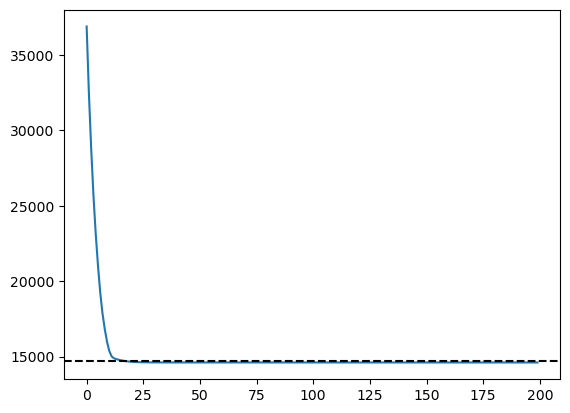

In [65]:
plt.plot(losses)
plt.axhline(loss(true_params), color='k', linestyle='--')

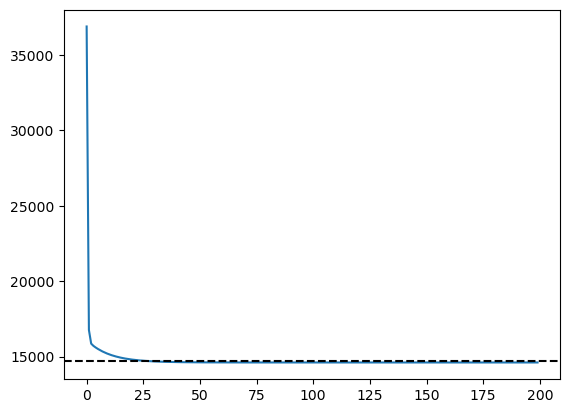

In [48]:
plt.plot(losses)
plt.axhline(loss(true_params), color='k', linestyle='--')

In [438]:
pred = Predictive(model, posterior_samples=jax.tree_map(lambda x: jnp.atleast_1d(x)[None,:], params))
opt_pred = pred(random.PRNGKey(2), x=x, args=args, y_obs=y_obs)

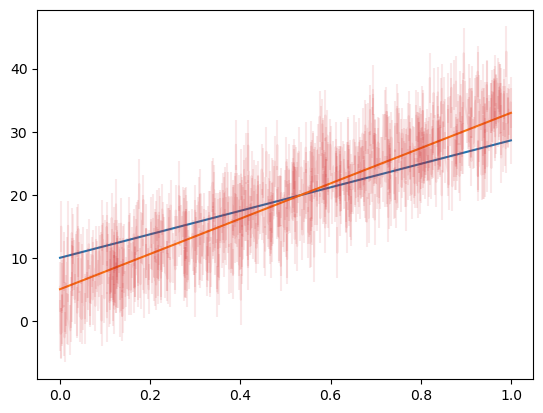

In [439]:
for i in range(4, 5):
    plt.plot(x[:,i], opt_pred['y'][0][:,i], color='tab:blue')
    plt.plot(x[:,i], y[:,i], color='tab:orange')
    plt.errorbar(x[:,i], y_obs[:,i], args['sigma'], color='tab:red', alpha=0.1)

In [ ]:
optax.GradientTransformation()